<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/validation_pipeline_precision_graph/kriging/ordinary_kriging_interpolation_highres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthengine-api geemap geopandas geobr rtree pyproj rasterio contextily descartes -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.1/928.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00
    

In [2]:
!pip install pykrige -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.6/852.6 kB 9.4 MB/s eta 0:00:00


In [3]:
## Import packages
import rasterio as rio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
import contextily as cx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geemap
import json
import seaborn as sns
from shapely.geometry import Point
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
import os

In [4]:
import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")

import ddfimport

ddfimport.ddf_source_control_pane()
# ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 5.50 KiB | 5.50 MiB/s, done.
Resolving deltas: 100% (4/4), done.


interactive(children=(Text(value='', description='Email', placeholder='Enter email'), Text(value='', descripti…

In [5]:
import importlib
import raster
importlib.reload(raster)

<module 'raster' from '/content/gdrive/MyDrive/main/ddf_common/raster.py'>

In [6]:
# Required to both import raster and read GDrive files
raster.RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
raster.SAMPLE_DATA_BASE = "/MyDrive/amazon_rainforest_files/amazon_sample_data/" #@param
raster.TEST_DATA_BASE = "/MyDrive/amazon_rainforest_files/amazon_test_data/" #@param
raster.ANIMATIONS_BASE = "/MyDrive/amazon_rainforest_files/amazon_animations/" #@param
raster.GDRIVE_BASE = "/content/gdrive" #@param

In [26]:
DEBUG = True #@param {type:"boolean"}
PROJECT_BASE = os.path.join(raster.GDRIVE_BASE, "MyDrive/amazon_rainforest_files")
# From PROJECT_BASE root
DATASET_PATH = "canonical/uc_davis_train_fixed_grouped.csv" #@param
DATASET_PATH_2 = "canonical/uc_davis_validation_fixed_grouped.csv" #@param
# From PROJECT_BASE root
BIOME_PATH = "christian_files/BR_UF_2021.shp" #@param
# From PROJECT_BASE root
OUTPUT_MEANS_ISOSCAPE_PATH = "amazon_rasters/canonical/highres_overall_means.tiff" #@param
OUTPUT_VARS_ISOSCAPE_PATH = "amazon_rasters/canonical/highres_overall_vars.tiff" #@param
ISOTOPE_COLUMN_NAME = "d18O_cel_mean" #@param
VARIOGRAM_MODEL = "linear" #@param

In [9]:
# Access data stored on Google Drive
if raster.GDRIVE_BASE:
    raster.mount_gdrive()

In [ ]:
if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

In [28]:
# Load coordinates and values from dataset path.
df = pd.concat([pd.read_csv(raster.get_sample_db_path(DATASET_PATH)).dropna(subset=['lat', 'long', ISOTOPE_COLUMN_NAME]),
                pd.read_csv(raster.get_sample_db_path(DATASET_PATH_2)).dropna(subset=['lat', 'long', ISOTOPE_COLUMN_NAME])], ignore_index=True)
long = df['long'].values
lat = df['lat'].values
isotope_values = df[ISOTOPE_COLUMN_NAME].values

In [12]:
def get_kriging_means_variances(
    bounds: raster.Bounds,
    long: list,
    lat: list,
    isotope_values: list,
    variogram_model: str = "linear"
):
  '''
  Gets the means and variances of an Ordinary Kriging model fit to the provided
  long, lat and isotope_values predicted on the coordinates within the bounds
  provided using the type of variogram_model specified.
  '''

  ok = OrdinaryKriging(
      long,
      lat,
      isotope_values,
      variogram_model=variogram_model,
      verbose=False,
      enable_plotting=True,
      enable_statistics=True,
      coordinates_type='geographic',
      pseudo_inv=True # this leads to more numerical stability and redundant
                      # points are averaged. This prevents singular matrix
                      # errors which happens frequently with variance isoscape
                      # in this method.
  )

  min_long, max_long, min_lat, max_lat = bounds.to_matplotlib()

  isoscape_long_values =  np.linspace(min_long, max_long, bounds.raster_size_x)
  isoscape_lat_values = np.linspace(min_lat, max_lat, bounds.raster_size_y)
  # Predict the isotope values on the range of lattitude and longitude values
  # within the bounds.
  means, variances  = ok.execute("grid", isoscape_long_values,
                                 isoscape_lat_values)
  ok.print_statistics()

  # Execute takes N longitude values and M latittude values and returns a
  # (M, N) matrix. Transpose to get (N, M) matrix so x and y are still longitude
  # and latitude respectively.
  return means.T, variances.T

In [13]:
def display_isoscape(means_filename, vars_filename, gdf_biome):
  '''
  Given a filename to a RasterIO file containing an isoscape raster,
  display the isoscape masked by the gdf_biome geometry.
  '''
  # Mean Isotope Isoscape Band Image
  means_raster = rasterio.open(means_filename)
  means_image, means_transform = rio.mask.mask(means_raster, gdf_biome.geometry.values, crop = True)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
  means_raster_images = show(means_image, ax = ax1, transform = means_transform, cmap = "RdYlGn")
  means_raster_image = means_raster_images.get_images()[0]
  fig.colorbar(means_raster_image, ax=ax1, shrink=0.3)

  ax1.set_title("Mean Isotope Isoscape Band")

  # Variance Isotope Isoscape Band Image
  vars_raster = rasterio.open(vars_filename)
  vars_image, vars_transform = rio.mask.mask(vars_raster, gdf_biome.geometry.values, crop = True)

  vars_raster_images = show(vars_image, ax = ax2, transform = vars_transform, cmap = "RdYlGn")
  vars_raster_image = vars_raster_images.get_images()[0]
  fig.colorbar(vars_raster_image, ax=ax2, shrink=0.3)

  ax2.set_title("Variance Isotope Isoscape Band")
  plt.show()

In [14]:
# TODO: Use standard raster dimensions and resolution.
atmosphere_isoscape_geotiff = raster.load_raster(raster.get_raster_path("variational_kriging_random_ablated_no_val_2023_08_03_means.tiff"))
bounds =  raster.get_extent(atmosphere_isoscape_geotiff.gdal_dataset)

Driver: GTiff/GeoTIFF
Size is 942 x 936 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0, 5.25)
Pixel Size = (0.041666666666666664, -0.041666666666666664)


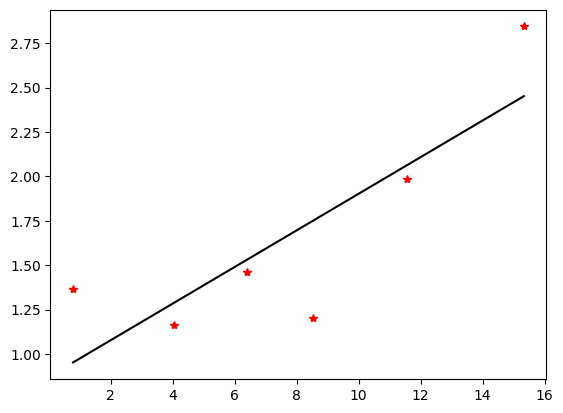

Q1 = 0.24102111786744274
Q2 = 1.4522225974455385
cR = 1.5613579759566576


In [29]:
means, variances = get_kriging_means_variances(bounds, long, lat, isotope_values, variogram_model=VARIOGRAM_MODEL)

In [30]:
out_filename_mean = os.path.join(PROJECT_BASE, OUTPUT_MEANS_ISOSCAPE_PATH)
out_filename_var = os.path.join(PROJECT_BASE, OUTPUT_VARS_ISOSCAPE_PATH)

means_masked_array = np.ma.masked_array(
    np.expand_dims(np.array(means), axis=2), mask=np.isnan(means))
variances_masked_array = np.ma.masked_array(
    np.expand_dims(np.array(variances), axis=2), mask=np.isnan(variances))

raster.save_numpy_to_geotiff(bounds, means_masked_array, out_filename_mean)
raster.save_numpy_to_geotiff(bounds, variances_masked_array, out_filename_var)

In [17]:
# Load geometry dataset that'll be used to mask isoscape in expected shape.
biome_path = os.path.join(PROJECT_BASE, BIOME_PATH)
gdf_biome = gpd.read_file(biome_path)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


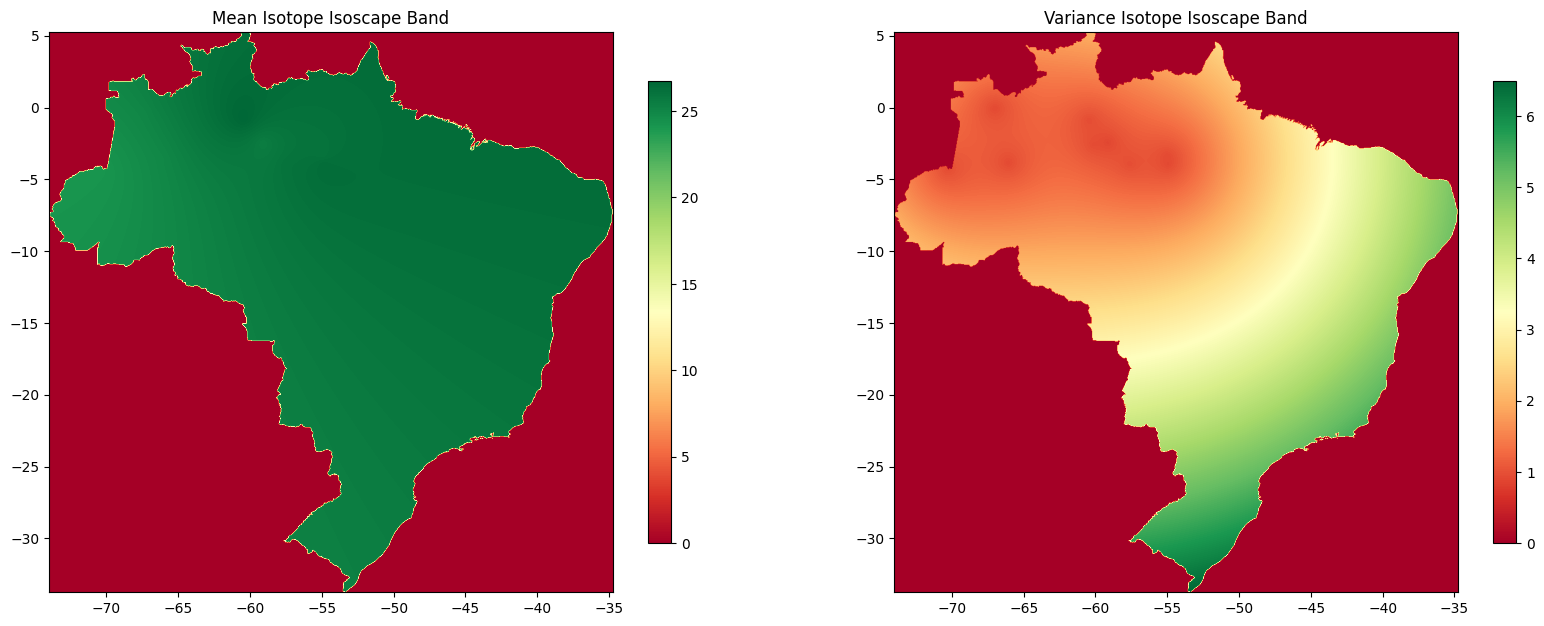

In [31]:
display_isoscape(out_filename_mean, out_filename_var, gdf_biome)